In [2]:
!pip install opencv-python
!pip install torch torchvision
!pip install scikit-learn
!pip install tqdm

  Using cached opencv_python-4.5.5.64-cp36-abi3-macosx_10_15_x86_64.whl (46.3 MB)
  Using cached torch-1.11.0-cp39-none-macosx_10_9_x86_64.whl (129.9 MB)
  Using cached torchvision-0.12.0-cp39-cp39-macosx_10_9_x86_64.whl (1.2 MB)


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import argparse
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

In [3]:
image_dir = '/Users/narendraomprakash/Desktop/Narendra/Semester-VI-WINTER2021/Image Processing/JCOM/Datasets/HK_dataset/Deblurring-3/saved_images'
os.makedirs(image_dir, exist_ok=True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
batch_size = 2

cpu


In [4]:
gauss_blur = os.listdir('/Users/narendraomprakash/Desktop/Narendra/Semester-VI-WINTER2021/Image Processing/JCOM/Datasets/HK_dataset/Deblurring-3/gaussian_blurred')
gauss_blur.sort()
sharp = os.listdir('/Users/narendraomprakash/Desktop/Narendra/Semester-VI-WINTER2021/Image Processing/JCOM/Datasets/HK_dataset/img')
sharp.sort()
x_blur = []
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])
y_sharp = []
for i in range(len(sharp)):
    y_sharp.append(sharp[i])

In [5]:
#75-25 split
(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.25)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")

Train data instances: 105266
Validation data instances: 35089


In [6]:
# convert to PIL->Resize to 224x224->image tensors
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        blur_image = cv2.imread(f"/Users/narendraomprakash/Desktop/Narendra/Semester-VI-WINTER2021/Image Processing/JCOM/Datasets/HK_dataset/Deblurring-3/gaussian_blurred/{self.X[i]}")
        
        if self.transforms:
            blur_image = self.transforms(blur_image)
            
        if self.y is not None:
            sharp_image = cv2.imread(f"/Users/narendraomprakash/Desktop/Narendra/Semester-VI-WINTER2021/Image Processing/JCOM/Datasets/HK_dataset/img/{self.y[i]}")
            sharp_image = self.transforms(sharp_image)
            return (blur_image, sharp_image)
        else:
            return blur_image

In [8]:
train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)

In [9]:
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [10]:
class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x
model = DeblurCNN().to(device)
print(model)

DeblurCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [11]:
criterion = nn.MSELoss()

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.5,
        verbose=True
    )

In [13]:
def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss/len(dataloader.dataset)
    print(f"Train Loss: {train_loss:.5f}")
    
    return train_loss

In [14]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            if epoch == 0 and i == int((len(val_data)/dataloader.batch_size)-1):
                save_decoded_image(sharp_image.cpu().data, name=f"/Users/narendraomprakash/Desktop/Narendra/Semester-VI-WINTER2021/Image Processing/JCOM/Datasets/HK_dataset/Deblurring-3/saved_images/sharp{epoch}.jpg")
                save_decoded_image(blur_image.cpu().data, name=f"/Users/narendraomprakash/Desktop/Narendra/Semester-VI-WINTER2021/Image Processing/JCOM/Datasets/HK_dataset/Deblurring-3/saved_images/blur{epoch}.jpg")
            if i == int((len(val_data)/dataloader.batch_size)-1):
                save_decoded_image(outputs.cpu().data, name=f"/Users/narendraomprakash/Desktop/Narendra/Semester-VI-WINTER2021/Image Processing/JCOM/Datasets/HK_dataset/Deblurring-3/saved_images/val_deblurred{epoch}.jpg")
        val_loss = running_loss/len(dataloader.dataset)
        print(f"Val Loss: {val_loss:.5f}")
        
        return val_loss

In [15]:
train_loss=[]
val_loss=[]

In [17]:
start = time.time()
for epoch in range(10):
    print(f"Epoch {epoch+1} of 10")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 1 of 10


100%|███████████████████████████████████| 52633/52633 [5:08:31<00:00,  2.84it/s]


Train Loss: 0.00356


17545it [41:24,  7.06it/s]                                                      


Val Loss: 0.00341
Epoch 2 of 10


100%|███████████████████████████████████| 52633/52633 [3:55:22<00:00,  3.73it/s]


Train Loss: 0.00336


17545it [31:58,  9.14it/s]                                                      


Val Loss: 0.00331
Epoch 3 of 10


100%|███████████████████████████████████| 52633/52633 [3:52:22<00:00,  3.77it/s]


Train Loss: 0.00333


17545it [32:02,  9.13it/s]                                                      


Val Loss: 0.00327
Epoch 4 of 10


100%|███████████████████████████████████| 52633/52633 [4:21:59<00:00,  3.35it/s]


Train Loss: 0.00331


17545it [41:12,  7.09it/s]                                                      


Val Loss: 0.00324
Epoch 5 of 10


100%|███████████████████████████████████| 52633/52633 [4:12:45<00:00,  3.47it/s]


Train Loss: 0.00330


17545it [40:06,  7.29it/s]                                                      


Val Loss: 0.00322
Epoch 6 of 10


100%|███████████████████████████████████| 52633/52633 [4:57:59<00:00,  2.94it/s]


Train Loss: 0.00328


17545it [35:21,  8.27it/s]                                                      


Val Loss: 0.00325
Epoch 7 of 10


100%|███████████████████████████████████| 52633/52633 [3:56:08<00:00,  3.71it/s]


Train Loss: 0.00327


17545it [32:52,  8.90it/s]                                                      


Val Loss: 0.00321
Epoch 8 of 10


100%|███████████████████████████████████| 52633/52633 [7:03:45<00:00,  2.07it/s]


Train Loss: 0.00326


17545it [2:53:50,  1.68it/s]                                                    


Val Loss: 0.00327
Epoch 9 of 10


100%|███████████████████████████████████| 52633/52633 [4:15:49<00:00,  3.43it/s]


Train Loss: 0.00325


17545it [45:13,  6.47it/s]                                                      


Val Loss: 0.00321
Epoch 10 of 10


100%|███████████████████████████████████| 52633/52633 [4:46:46<00:00,  3.06it/s]


Train Loss: 0.00324


17545it [32:53,  8.89it/s]                                                      

Val Loss: 0.00321
Took 3298.485 minutes to train


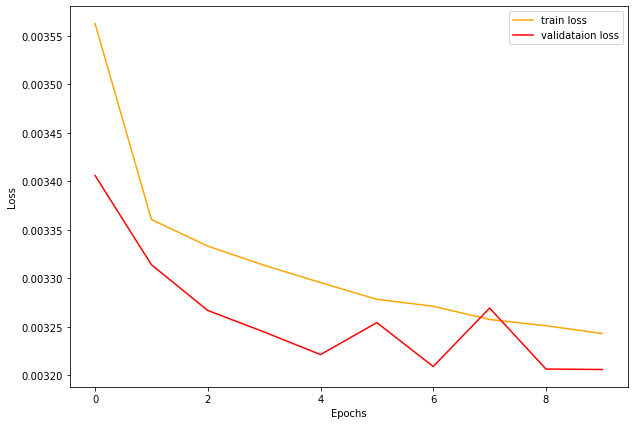

Saving model...


In [18]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/Users/narendraomprakash/Desktop/Narendra/Semester-VI-WINTER2021/Image Processing/JCOM/Datasets/HK_dataset/Deblurring-3/loss.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), '/Users/narendraomprakash/Desktop/Narendra/Semester-VI-WINTER2021/Image Processing/JCOM/Datasets/HK_dataset/Deblurring-3/model.pth')